Importando os pacotes

In [6]:
import xarray as xr
from xskillscore import rmse

Importando os dados no formato `.nc` e atribuindo a variáveis

In [ ]:
observation = xr.open_dataset('observation.nc')
forecast = xr.open_dataset('forecast.nc')
print(observation, forecast)

Uniformizando as coordenadas e variáveis (forecast está com a variável 't2m')

In [3]:
forecast.coords['lat'] = observation['lat']
forecast.coords['lon'] = observation['lon']


observation = observation.rename_vars({'temperatura': 'observation'})
forecast = forecast.rename_vars({'t2m': 'forecast'})

Conversão de Kelvin para grau Celsius

In [ ]:
forecast['forecast'] = forecast['forecast'] -273.15
forecast['forecast']

Cálculo do índice RMSE para cada intervalo de 6 horas

In [5]:
df = xr.merge([observation, forecast])

rmse_6h = df.resample(time='6h').apply(lambda x: rmse(x['observation'], x['forecast'], dim='time')).rename('rmse')

rmse_6h.to_netcdf('RMSE_6hourly.nc', 'w')

Plotando série temporal

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

sns.set_style('darkgrid')

In [9]:
observation_6h_sp = observation.resample(time='6h').mean().sel(lat=-23.5489, lon=-46.6388, method='nearest')
observation_6h_sp

forecast_6h_sp = forecast.resample(time='6h').mean().sel(lat=-23.5489, lon=-46.6388, method='nearest')
forecast_6h_sp

rmse_6h_sp = rmse_6h.sel(lat=-23.5489, lon=-46.6388, method='nearest')
rmse_6h_sp = rmse_6h_sp.to_dataset()

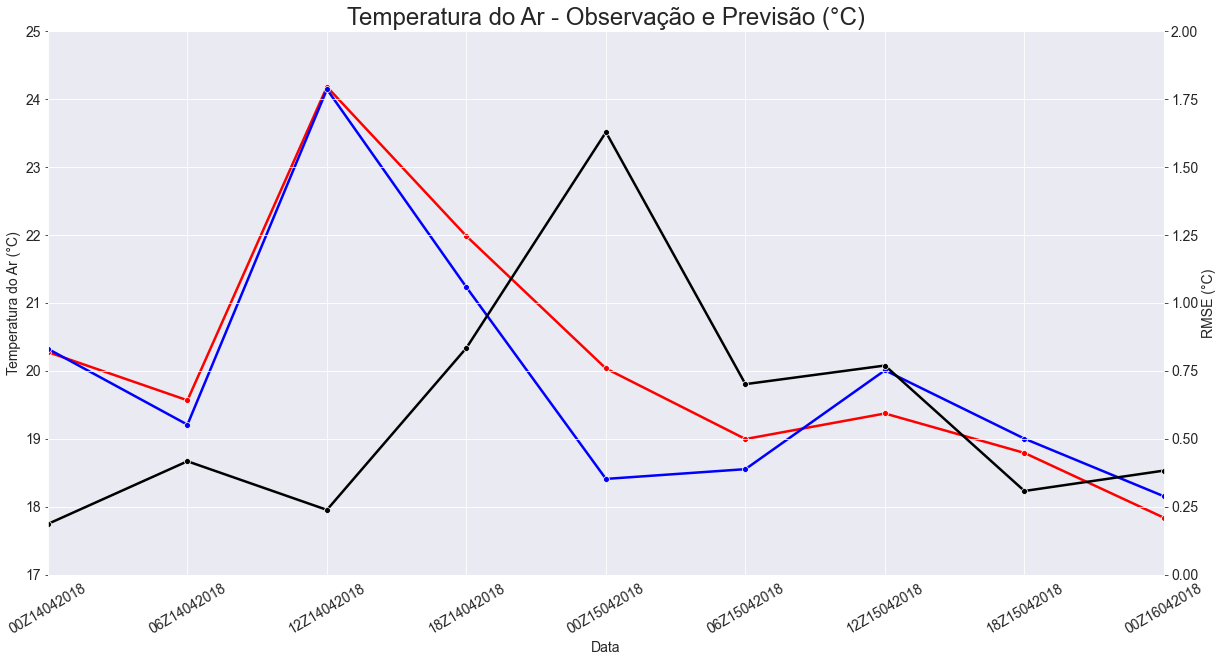

In [55]:
#plot da observação
axes_1 = sns.lineplot(x='time',
                  y='observation',
                  data=observation_6h_sp,
                  marker='o',
                  lw=2.5,
                  color='red')
#plot da previsão
axes_2 = sns.lineplot(x='time',
                  y='forecast',
                  data=forecast_6h_sp,
                  marker='o',
                  lw=2.5,
                  color='blue')
#criação de um eixo secundário para o plot do RMSE
axes_3 = axes_1.twinx()

axes_3 = sns.lineplot(x='time',
                  y='rmse',
                  data=rmse_6h_sp,
                  marker='o',
                  lw=2.5,
                  color='black')
#configurações do gráfico
axes_1.figure.set_size_inches(20, 10)

axes_1.set_title('Temperatura do Ar - Observação e Previsão (°C)', fontsize=24)

axes_1.set_xlabel('Data', fontsize=14)
axes_1.set_ylabel('Temperatura do Ar (°C)', fontsize=14)
axes_3.set_ylabel('RMSE (°C)', fontsize=14)

axes_1.tick_params(axis='x', rotation=30, labelsize=14)
axes_2.tick_params(labelsize=14)
axes_3.tick_params(labelsize=14)
axes_1.set_ylim([17,25])
axes_3.set_ylim([0,2])

datas = [datetime.date(2018, 4, 14), datetime.date(2018, 4, 16)]
plt.xlim([datas[0], datas[-1]])
axes_1.xaxis.set_major_formatter(mdates.DateFormatter('%HZ%d%m%Y'))
plt.savefig("air_temp_sp.png", dpi=300)